In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import cross_val_score

from tradPointOut import rankToPoints2017
from tabulabuilder import School

sns.set_style("whitegrid")

In [18]:
rawDf = pd.read_csv("data/tier7QLonly.csv")
df = rawDf.copy()
df.isRelay = df.isRelay.astype(int)

# strokes = df.pop("stroke")
# strokesOneHot = pd.get_dummies(strokes, prefix="stroke")
# df = pd.concat([df, strokesOneHot], axis=1)

In [19]:
df2018 = df.loc[df["year"] == 2018]
testSet = df2018.sample(frac = 0.7, random_state = 33)
testY = testSet.pop("points")
testX = testSet.copy()

trainSet = df[~df.index.isin(testSet.index)]
trainY = trainSet.pop("points")
trainX = trainSet.copy()

xCols = ["divsSpeed", "isRelay", "divsTimePctOfMean",  "clipped_divsRank"]
#, "stroke_Backstroke", "stroke_Breaststroke", "stroke_Freestyle", "stroke_Medley", "stroke_IM", "stroke_Butterfly"]

y2018 = df2018["points"]
x2018 = df2018[xCols]

trainX = trainX[xCols] 
testX = testX[xCols] 

In [20]:
from sklearn.svm import SVR

svr = SVR(gamma = "scale", kernel="rbf")
svr = svr.fit(trainX, trainY)
scores = cross_val_score(svr, trainX, trainY, cv=4)
print(f"R^2: {scores.mean()} (+/- {scores.std() * 2})")

R^2: 0.745489048227956 (+/- 0.1950747103943089)


In [21]:
svrY = svr.predict(x2018)
svrErrors = y2018 - svrY
print("MAE:", svrErrors.abs().mean())
df2018["svrPred"] = svrY
df2018["svrError"] = svrErrors

MAE: 1.5104170519899087
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
df2018["tradPred"] = df.apply(lambda row: rankToPoints2017(row["divsRank"]), axis=1)
df2018["tradError"] = df2018["points"] - df2018["tradPred"]

c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


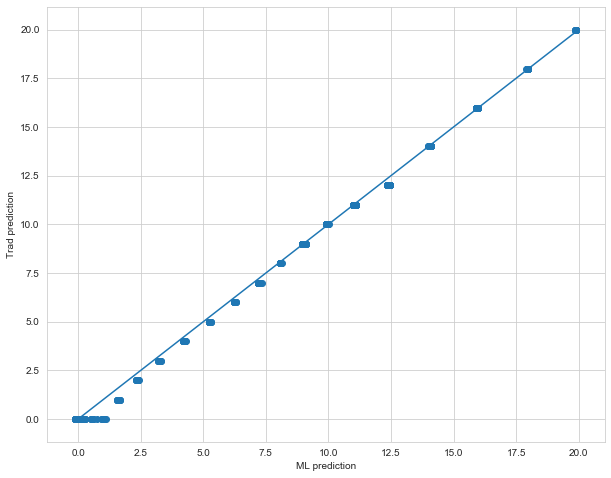

In [23]:
plt.figure(figsize = (10,8))
plt.xlabel("ML prediction")
plt.ylabel("Trad prediction")
lineX = np.linspace(0,20,20)
plt.plot(lineX, lineX)
plt.scatter(df2018["svrPred"], df2018["tradPred"])


In [74]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=250, criterion="mse", min_samples_leaf=64)
rfr = rfr.fit(trainX, trainY)
scores = cross_val_score(rfr, trainX, trainY, cv=4)
print(f"R^2: {scores.mean()} (+/- {scores.std() * 2})")

rfrY = rfr.predict(x2018)
rfrErrors = y2018 - rfrY
print("MAE:", rfrErrors.abs().mean())
df2018["rfrPred"] = rfrY
df2018["rfrError"] = rfrErrors

R^2: 0.7460310860401655 (+/- 0.17350574076857564)
MAE: 1.7334091022877072
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


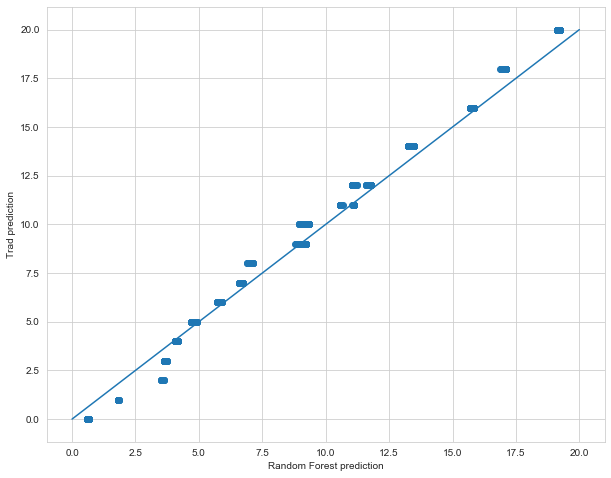

In [75]:
plt.figure(figsize = (10,8))
plt.xlabel("Random Forest prediction")
plt.ylabel("Trad prediction")
lineX = np.linspace(0,20,20)
plt.plot(lineX, lineX)
plt.scatter(df2018["rfrPred"], df2018["tradPred"])

In [76]:
pd.DataFrame([xCols, rfr.feature_importances_])

,0,1,2,3
0,divsSpeed,isRelay,divsTimePctOfMean,clipped_divsRank
1,0.000749368,0,0.0029908,0.99626


In [77]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=2000, criterion="friedman_mse", min_samples_leaf=64, learning_rate=0.1)
gbr = gbr.fit(trainX, trainY)
scores = cross_val_score(gbr, trainX, trainY, cv=4)
print(f"R^2: {scores.mean()} (+/- {scores.std() * 2})")

gbrY = gbr.predict(x2018)
gbrErrors = y2018 - gbrY
print("MAE:", gbrErrors.abs().mean())
df2018["gbrPred"] = gbrY
df2018["gbrError"] = gbrErrors

pd.DataFrame([xCols, gbr.feature_importances_])

R^2: 0.7243516790323855 (+/- 0.19094755634241642)
MAE: 1.7127097892004486
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\Users\tang-\Documents\Python Scripts\skynet2\skynetvenv\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,0,1,2,3
0,divsSpeed,isRelay,divsTimePctOfMean,clipped_divsRank
1,0.0293499,0.00107426,0.0427699,0.926806


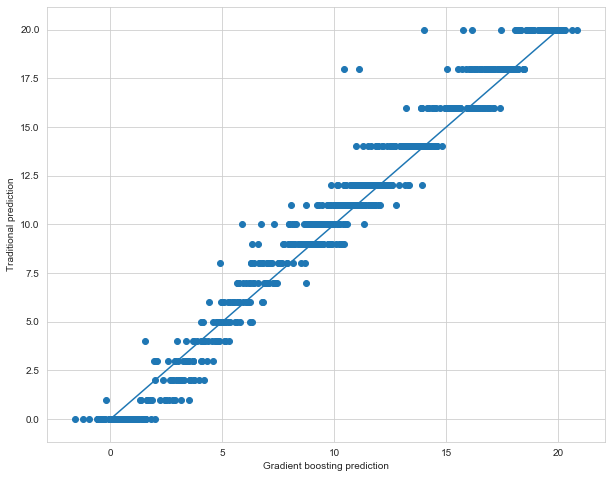

In [78]:
plt.figure(figsize = (10,8))
plt.xlabel("Gradient boosting prediction")
plt.ylabel("Traditional prediction")
lineX = np.linspace(0,20,20)
plt.plot(lineX, lineX)
plt.scatter(df2018["gbrPred"], df2018["tradPred"])

In [79]:
estimators = ["svr", "gbr", "rfr", "trad"]
errorHistDf = pd.DataFrame(columns=["points", "error", "estimator"])
for estimator in estimators:
    errColName = f"{estimator}Error"
    estimatorErrorDf = df2018[["points", errColName]].copy()
    estimatorErrorDf["estimator"] = estimator
    estimatorErrorDf = estimatorErrorDf.rename(columns={errColName: "error"})
    errorHistDf = errorHistDf.append(estimatorErrorDf)

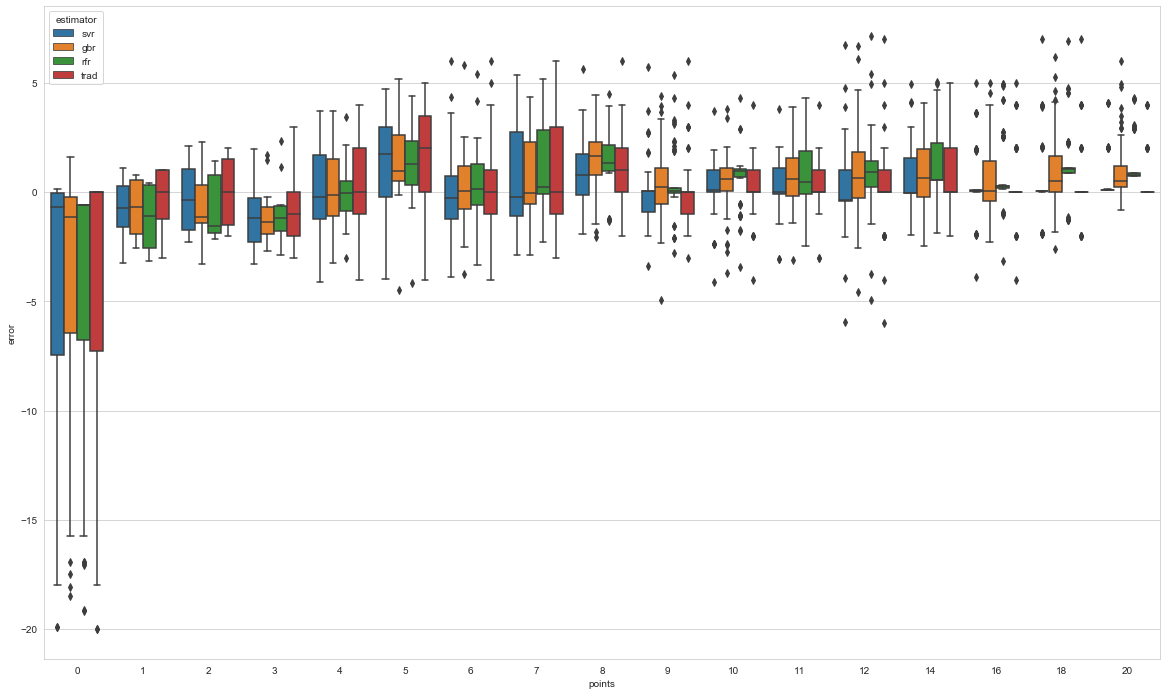

In [80]:
plt.figure(figsize = (20,12))
sns.boxplot(x = "points", y = "error", hue = "estimator", data = errorHistDf)

<Figure size 864x576 with 0 Axes>

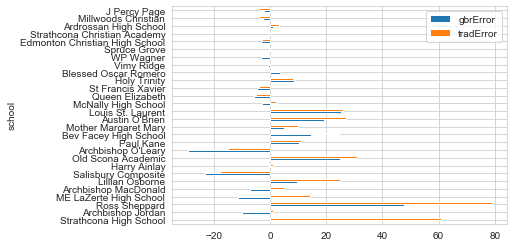

In [84]:
preds = pd.pivot_table(
    df2018, 
    index = "school", 
    values = "points",
    aggfunc = np.sum
)

preds.insert(
    0, "school",
    preds.index.map(lambda idx: School.get_by_id(idx).name)
)

for est in estimators:

    estCol = f"{est}Pred"

    estSum = pd.pivot_table(
        df2018, 
        index = "school", 
        values = estCol,
        aggfunc = np.sum
    )

    preds = pd.concat([preds, estSum], axis = 1)
    preds[f"{est}Error"] = preds[estCol] - preds["points"]
    

preds = preds.sort_values(by = "points", ascending = False)
plt.figure(figsize = (12, 8))
preds.plot.barh(x = "school", y = ["gbrError", "tradError"])


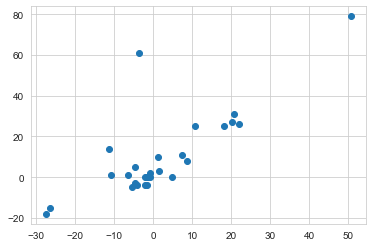

In [85]:
plt.scatter(preds["rfrError"], preds["tradError"])

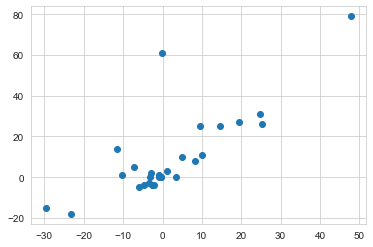

In [86]:
plt.scatter(preds["gbrError"], preds["tradError"])